In [1]:
%matplotlib inline
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import time
import jax
import genjax

from genjax import grasp

from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import pyro
from optax import adam

# the only pyro dependency
import pyro.contrib.examples.multi_mnist as multi_mnist

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format="%(message)s", level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use("default")
label_fontsize = 70  # Set the desired font size here

In [2]:
ϕ = (0.0, 0.0, 1.0, 1.0)

## Model

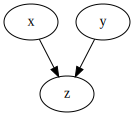

In [3]:
def model():
    x = pyro.sample("x", dist.Normal(0.0, 10.0))
    y = pyro.sample("y", dist.Normal(0.0, 10.0))
    rs = x**2 + y**2
    z = pyro.sample("z", dist.Normal(rs, 0.1 + (rs / 100.0)))
    return (x, y, z)


pyro.render_model(model, model_args=())

In [4]:
with pyro.plate("samples", 2000, dim=-1):
    samples = model()
x, y, z = samples

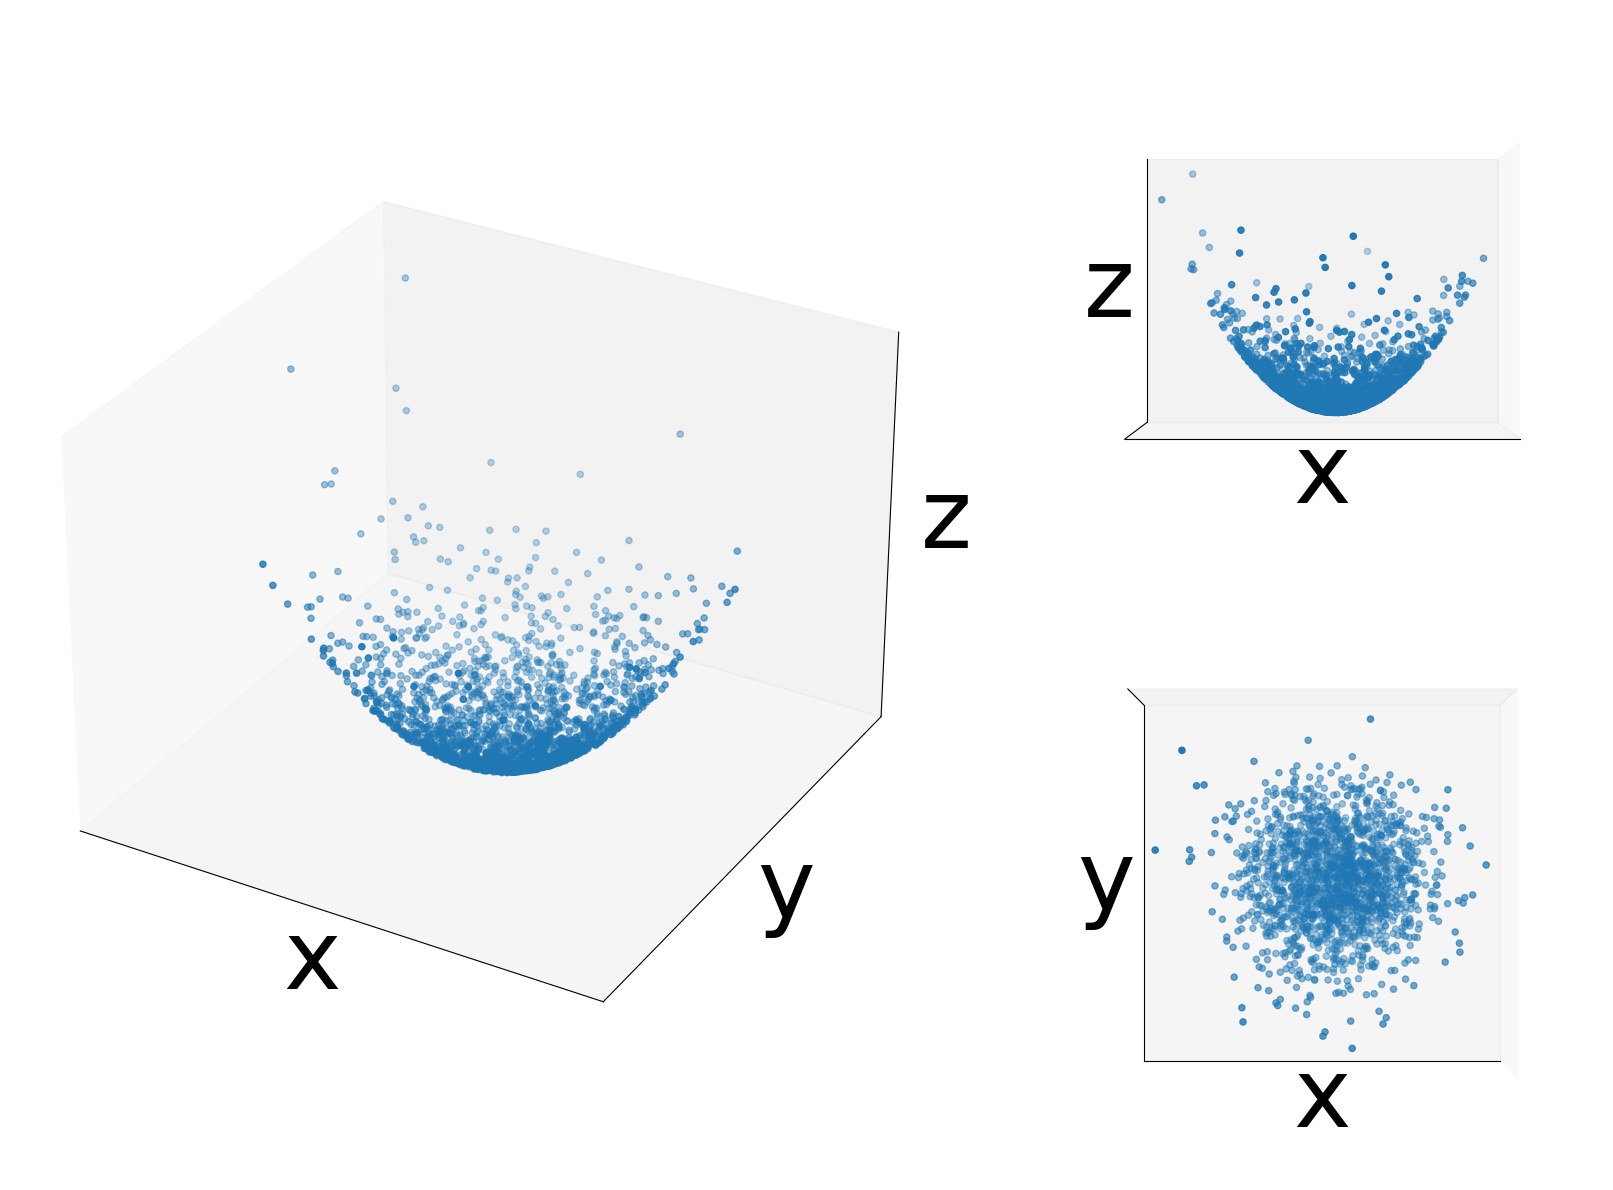

In [5]:
# Create a new figure
fig = plt.figure(figsize=(18, 12))  # Adjust the size for better visualization

gs = GridSpec(2, 2, height_ratios=[1, 1])

# First subplot - Original 3D plot
ax1 = fig.add_subplot(gs[:, 0], projection="3d")  # This spans both columns
ax1.scatter(x, y, z)
ax1.set_xlabel("x", fontsize=label_fontsize)
ax1.set_ylabel("y", fontsize=label_fontsize)
ax1.set_zlabel("z", fontsize=label_fontsize)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

# Second subplot - Rotated 3D plot looking at the XZ plane
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
ax2.scatter(x, y, z)
ax2.set_xlabel("x", fontsize=label_fontsize)
ax2.set_zlabel("z", fontsize=label_fontsize)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.view_init(elev=0, azim=-90)

# Third subplot - Rotated 3D plot looking at the XZ plane
ax3 = fig.add_subplot(gs[1, 1], projection="3d")
ax3.scatter(x, y, z)
ax3.set_xlabel("x", fontsize=label_fontsize)
ax3.set_ylabel("y", fontsize=label_fontsize)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])
ax3.view_init(elev=90, azim=-90)


# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

plt.show()

## Naive variational guide

In [6]:
softplus = torch.nn.Softplus()

# Now, we define our variational proposal.
def guide():
    μ1 = pyro.param("mu1", torch.tensor(0.0))
    μ2 = pyro.param("mu2", torch.tensor(0.0))
    log_σ1 = pyro.param("log_sigma1", torch.tensor(1.0))
    log_σ2 = pyro.param("log_sigma2", torch.tensor(1.0))
    x = pyro.sample("x", dist.Normal(μ1, torch.exp(log_σ1)))
    y = pyro.sample("y", dist.Normal(μ2, torch.exp(log_σ2)))

## Training

Guessed max_plate_nesting = 1
Elbo loss: 874.0497436523438
Elbo loss: 8.160330772399902
Elbo loss: 8.073073387145996
Elbo loss: 7.828956604003906
Elbo loss: 8.112361907958984
Elbo loss: 8.064537048339844
Elbo loss: 8.143707275390625
Elbo loss: 8.050674438476562
Elbo loss: 7.893946647644043
Elbo loss: 8.085652351379395
Elbo loss: 7.942660808563232
Elbo loss: 8.187673568725586
Elbo loss: 7.983965873718262
Elbo loss: 8.017991065979004
Elbo loss: 8.117130279541016
Elbo loss: 8.065905570983887
Elbo loss: 8.157095909118652
Elbo loss: 7.92179012298584
Elbo loss: 8.068059921264648
Elbo loss: 8.061666488647461


mu1 0.0066194064
mu2 2.2214265
log_sigma1 -1.2788647
log_sigma2 -3.3876197


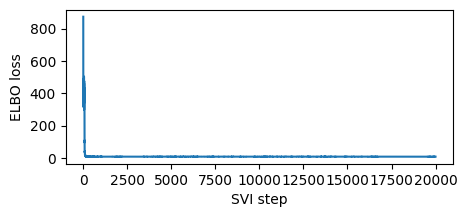

In [7]:
pyro.clear_param_store()
data = torch.tensor(5.0)

# These should be reset each training loop.
adam = pyro.optim.SGD({"lr": 1.0e-3})  # Consider decreasing learning rate.
elbo = pyro.infer.TraceGraph_ELBO(num_particles=64, vectorize_particles=True)
conditioned_model = pyro.condition(model, data={"z": data})
svi = pyro.infer.SVI(conditioned_model, guide, adam, elbo)

losses = []
for step in range(20000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step()
    losses.append(loss)
    if step % 1000 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

In [15]:
(torch.tensor(losses)[1000:].mean(), torch.tensor(losses)[1000:].std())

(tensor(8.0854), tensor(0.1167))

## Training (IWAE)

Guessed max_plate_nesting = 1
Elbo loss: 90.32416534423828
Elbo loss: 5.875807762145996
Elbo loss: 7.309023380279541
Elbo loss: 6.512497901916504
Elbo loss: 6.803735256195068
Elbo loss: 14.850077629089355
Elbo loss: 6.790671348571777
Elbo loss: 8.797954559326172
Elbo loss: 6.192967414855957
Elbo loss: 7.232148170471191
Elbo loss: 8.196480751037598
Elbo loss: 7.0854387283325195
Elbo loss: 7.319985389709473
Elbo loss: 8.807365417480469
Elbo loss: 4.805910110473633
Elbo loss: 10.059679985046387
Elbo loss: 7.153384208679199
Elbo loss: 7.137782573699951
Elbo loss: 6.968308925628662
Elbo loss: 7.442228317260742


mu1 -2.093424
mu2 -0.13232389
log_sigma1 -2.4308276
log_sigma2 -0.57241136


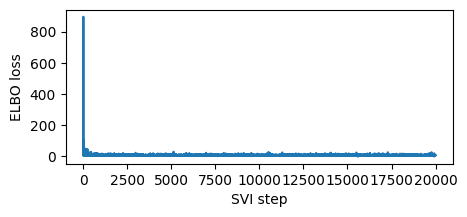

In [17]:
pyro.clear_param_store()
data = torch.tensor(5.0)

# These should be reset each training loop.
adam = pyro.optim.SGD({"lr": 1.0e-3})  # Consider decreasing learning rate.
elbo = pyro.infer.RenyiELBO(num_particles=5, vectorize_particles=True)
conditioned_model = pyro.condition(model, data={"z": data})
svi = pyro.infer.SVI(conditioned_model, guide, adam, elbo)

losses = []
for step in range(20000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step()
    losses.append(loss)
    if step % 1000 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

In [18]:
(torch.tensor(losses)[1000:].mean(), torch.tensor(losses)[1000:].std())

(tensor(7.7595), tensor(1.5830))